# **Self-supervised Learning: Fashionset Classification**
## Advanced Topics in Machine Learning Project Report
University of Bern, 2019

## Goal of the project
The task we chose is classifying the DeepFashion Dataset (http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) which consists of approximately 290'000 images of clothing items, separated in 50 categories. 

## Description of the methods

We implement self-supervised methods with three different self-supervised tasks. We first trained a CIFAR-Net network (*link*) for every sub-task using unlabeled images. Afterwards, we added a linear classifier on top of it, fine-tuned said classifier using labeled images and predicted the images categories. Training for the sub-tasks and fine-tuning was made using the Cross-Entropy loss function, with Adam optimizers and decaying learning rates. 

We used the FashionMNIST dataset (https://github.com/zalandoresearch/fashion-mnist https://arxiv.org/abs/1708.07747 by Xiao et al.) to train our CIFAR-Net in the subtasks. This dataset comprises 70'000 images in 10 categories. 

Here are the three different sub-tasks.

- Rotation prediction (based on https://github.com/gidariss/FeatureLearningRotNet / https://openreview.net/pdf?id=S1v4N2l0- by Gidaris et al.). 

    Here, the CIFAR-Net network is trained to predict how many times the unlabeled images were rotated. We then use labeled images to fine-tune the last two linear layers that will serve as classifier. The code is found in `rotation.py` .

- Discriminative feature learning with Exemplar CNN (based on https://arxiv.org/abs/1406.6909 by Dosovitskiy et al.)

    For this sub-task, each image is randomly transformed via either a horizontal flip, cropping, resized cropping, color jitter, rotation or affine transformation. The network then learns to assign a unique class to all the variants of each image. As for the other tasks, we then add a linear classifier and fine-tune it. This sub-task is found under `exemplar_cnn.py` 

- Auto-Encoding Transformations (based on https://arxiv.org/abs/1901.04596 by Qi et al.)

    Each image receives a random affine transformation. We then train an auto-encoder that tries to predict the 8 parameters of the transformation. The encoder is again the CIFAR-Net and the decoder is built accordingly. The code for this sub-task is found in `AET.py` and `decoder.py`.

In addition, we also directly trained our network with supervised learning to allow us to have a comparison. The CIFAR-Net is directly trained with the DeepFashion dataset, we can find the code in `supervised_deep_fashion.py` . 

## Examples of Use

You just need to download the deepfashion dataset and place it in the root directory in a folder called /img. 

- The dataset can be found under: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.

After that the only thing you need to do is execute the main.py file. This will start the whole process.

1. The main.py file will then start the training of the different methods with the FashionMNIST.
2. After the training the data gets finetuned with the DeepFashion dataset
3. In a final step we evalute each method with a the testset of the DeepFashion dataset

In each step we are able to plot the curves and to compare the results. These plots get saved in a folder named /Plot.

In [5]:
# Here are some sample images from the FashionMnist and DeepFashion Dataset
# First we need to import some libraries, so we can display the pictures.
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from PIL import Image

# after that we need to load the two datasets
fashionmnist = torchvision.datasets.FashionMNIST('fashion_mnist/', train=True, transform=None, target_transform=None, download=False)
        


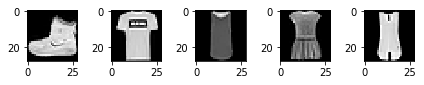

In [6]:
# here are some pictures of the fashionMNIST dataset
fig = plt.figure()
for i in range (len(fashionmnist)):
    sampleImg = fashionmnist[i][0]
    fig.add_subplot(1,5,i+1)
    plt.imshow(sampleImg, cmap='gray')
    plt.tight_layout()
    if i == 4:   
        plt.show()  
        break

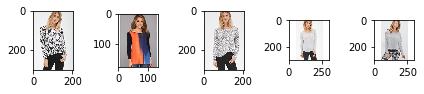

In [4]:
# here are some pictures of the DeepFashion dataset
# in the dataloader they all get scaled to the size of 32x32 pixel

image1 = Image.open('img/Abstract_Brushstroke_Pocket_Top/img_00000001.jpg')
image2 = Image.open('img/Abstract_Brushstroke_Pocket_Top/img_00000002.jpg')
image3 = Image.open('img/Abstract_Brushstroke_Pocket_Top/img_00000003.jpg')
image4 = Image.open('img/Abstract_Brushstroke_Pocket_Top/img_00000004.jpg')
image5 = Image.open('img/Abstract_Brushstroke_Pocket_Top/img_00000005.jpg')
deepfashion = [image1, image2, image3, image4, image5]

fig1 = plt.figure()
for i, img in enumerate(deepfashion):
    fig1.add_subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')    
    plt.tight_layout()

plt.show()


For each method we have different training methods. Here is a code snippet from the Image Rotation Prediction where we 
- Call the model.
- Define the loss, optimizer and scheduler.
- Train the network

```python
def train_rotation_net():

    """Trains the rotation model."""
    print("=============================================================")
    print("========== Train Rotation Model with FashionMNIST ===========")
    print("=============================================================\n")

    model = CifarNet(input_channels=1, num_classes=4)
    model = model.to(DEVICE)

    # Criteria NLLLoss which is recommended with Softmax final layer
    loss_fn = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 4 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=4, gamma=0.1)

    return train(model, loss_fn, optimizer, scheduler, EPOCHS, train_loader_fashion_mnist, val_loader_fashion_mnist)

```

Our model, called CifarNet is built like this:

```python
class CifarNet(nn.Module):
    """CifarNet model"""

    def __init__(self, input_channels, num_classes=10):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(5, 5), bias=False)
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.batch1 = nn.BatchNorm2d(num_features=64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5, 5), bias=False)
        self.batch2 = nn.BatchNorm2d(num_features=64)
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.flat = flatten
        self.fc1 = nn.Linear(1600, 384, bias=True)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192, bias=True)
        self.fc3 = nn.Linear(192, num_classes, bias=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.max1(out)
        out = self.batch1(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.max2(out)
        out = self.flat(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
```

After the training it is necessary that we finetune the model before we test it with the Deepfashion dataset:
- We define the loss function, optimizer and scheduler again
- Replace the last linear layer `self.fc3` by two fully connected layers 
- We freeze all layers except the last two ones. 
- In the last step we fine tune the model, because only the weights of the unfrozen layers will be modified. 
    
```python
def fine_tune_rotation_model(model):
    """Fine tunes the rotation model."""
    print("=============================================================")
    print("======== Fine Tune Rotation Model with FashionMNIST =========")
    print("=============================================================\n")

    # Criteria NLLLoss which is recommended with Softmax final layer
    loss_fn = nn.CrossEntropyLoss()

    # freezes all layers except the final one, according to the method parameters

    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc3.parameters():
        param.requires_grad = True

    # replace fc layer with 10 outputs
    model.fc3 = nn.Sequential(nn.Linear(192, 192),
                              nn.Linear(192, 10, bias=True)
                              )

    # Observe that all parameters are being optimized
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 4 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=4, gamma=0.1)

    model = model.to(DEVICE)
    return fine_tune(model, loss_fn, optimizer, scheduler, EPOCHS, train_loader_fashion_mnist, val_loader_fashion_mnist)

```

All that is left in the final step is to test the trained model on a testset for classification purposes. The test method looks like this:
- We keep the same loss function
- Replace the final fully connected part with two fully connected layers. <font color='red'>stimmt das?! verlieren wir die Weights nicht?</font>


```python
def test_classification_on_rotation_model(model):
    """Tests the rotation model."""
    print("=============================================================")
    print("== Test Classification on Rotation Model with FashionMNIST ==")
    print("=============================================================\n")

    # Criteria NLLLoss which is recommended with Softmax final layer
    loss_fn = nn.CrossEntropyLoss()

    # replace fc layer with 10 outputs
    model.fc3 = nn.Sequential(nn.Linear(192, 192),
                              nn.Linear(192, 10, bias=True)
                              )

    model = model.to(DEVICE)
    return test(model, loss_fn, EPOCHS, test_loader_fashion_mnist)
```